['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


Dataset ImageFolder
    Number of datapoints: 58954
    Root location: ./MedMNIST
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47163 11791
torch.Size([16, 3, 224, 224])


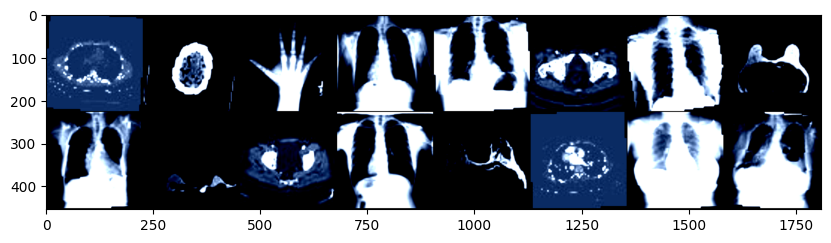

epoch: 0 loss: 1.5337512493133545 batch: 5 accuracy: 26.250%
epoch: 0 loss: 0.9902474880218506 batch: 10 accuracy: 30.000%
epoch: 0 loss: 0.641910970211029 batch: 15 accuracy: 43.333%
epoch: 0 loss: 0.2911040484905243 batch: 20 accuracy: 52.812%
epoch: 0 loss: 0.10973744839429855 batch: 25 accuracy: 62.000%
epoch: 0 loss: 0.12742336094379425 batch: 30 accuracy: 66.875%
epoch: 0 loss: 1.087407112121582 batch: 35 accuracy: 70.536%
epoch: 0 loss: 0.04323139786720276 batch: 40 accuracy: 73.438%
epoch: 0 loss: 0.00813694391399622 batch: 45 accuracy: 75.556%
epoch: 0 loss: 0.008290574885904789 batch: 50 accuracy: 77.625%
epoch: 0 loss: 0.014418335631489754 batch: 55 accuracy: 79.318%
epoch: 0 loss: 0.08205205202102661 batch: 60 accuracy: 80.729%
epoch: 0 loss: 0.03487054631114006 batch: 65 accuracy: 82.212%
epoch: 0 loss: 0.02199639566242695 batch: 70 accuracy: 83.482%
epoch: 0 loss: 0.07398208975791931 batch: 75 accuracy: 84.250%
epoch: 0 loss: 0.21959330141544342 batch: 80 accuracy: 84.766

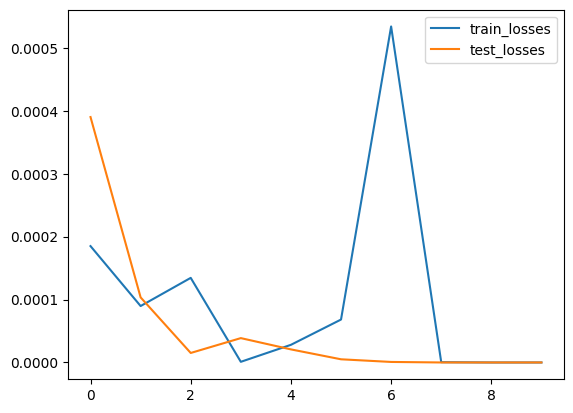

In [3]:
#ConvolutionalNetwork
import os
import random
import cv2
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

%matplotlib inline

dir0 = './MedMNIST' #定义变量dir0，存储图像数据的根目录路径。
names0 = os.listdir(dir0) #使用os.listdir函数列出目录dir0中的所有内容，包括文件和子目录。
names = sorted(names0) #对列出的文件和目录名进行字母排序。这步骤有助于确保处理的顺序是一致的，特别是在涉及到多个类别的数据时。
print(names)

#定义图像预处理的转换链：
train_transform = transforms.Compose([
    transforms.RandomRotation(10),      # rotate +/- 10 degrees，随机旋转图像最多10度。这种随机性可以提高模型对图像轻微旋转的鲁棒性。
    transforms.RandomHorizontalFlip(),  # reverse 50% of images，以50%的概率水平翻转图像。这种数据增强有助于模型学习对图像方向不敏感。
    transforms.Resize(224),             # resize shortest side to 224 pixels，将图像的最短边缩放至224像素，而保持图像的长宽比不变。
    transforms.CenterCrop(224),         # crop longest side to 224 pixels at center，从图像中心裁剪出224x224像素的区域。这确保了模型输入的一致性和集中性，特别是对于神经网络模型来说非常重要。
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #标准化处理，使用预设的均值和标准差按通道进行。这些数值通常是根据大型数据集（如ImageNet）预计算得出的，用于帮助模型更快地收敛。
])

dataset = datasets.ImageFolder(root=dir0, transform=train_transform) #创建一个图像文件夹数据集，该数据集将从dir0指定的根目录加载图像，并应用定义的train_transform转换链。
display(dataset)

class_names = dataset.classes
print(class_names)
print(len(class_names))

train_indices, test_indices = train_test_split(list(range(len(dataset.targets))), test_size=0.2, stratify=dataset.targets)
#使用train_test_split函数从数据集中分离出20%作为测试集，其余作为训练集。stratify=dataset.targets参数确保训练集和测试集中各类别的比例保持一致。
train_data = torch.utils.data.Subset(dataset, train_indices)
test_data = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16) #为训练集和测试集创建数据加载器，设置批处理大小为16，训练加载器设置shuffle=True以在每个训练周期中随机打乱数据顺序，这有助于减少模型过拟合并提高泛化能力。

print(len(train_data), len(test_data))

# Check the 1st batch
for images, labels in train_loader:
    break
print(images.shape)
im = make_grid(images, nrow=8)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
plt.show()

# Correct the normalization process
inv_normalize = transforms.Normalize( #用于归一化处理，这里的参数是为了将归一化后的图像数据恢复到原始数据的范围。
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im = inv_normalize(im)

class ConvolutionalNetwork(nn.Module): #它包括两个卷积层和四个全连接层。
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1) #分别初始化为接收3个通道输入并输出6个通道，以及接收6个通道输入并输出16个通道的卷积层，卷积核大小为3x3，步长为1。
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120) #注意16 * 54 * 54是根据卷积后的特征图尺寸计算的，这里假设输入经过两次卷积和池化后的空间尺寸为54x54。
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))
        
    def forward(self, X): #定义了数据如何流经网络。每个卷积层后应用ReLU激活函数和最大池化。
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54) #将多维的特征图展平为一维，以便作为全连接层的输入。
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

model = ConvolutionalNetwork()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #创建网络实例，并根据是否有可用的GPU来决定使用GPU还是CPU。
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

import time
start_time = time.time()
train_losses = []
test_losses = []
train_correct = []
test_correct = []
epochs = 10

for i in range(epochs): #循环控制整个训练过程重复执行指定次数，epochs是预设的训练周期数。
    trn_corr = 0 #用来记录每个周期中训练集和测试集上正确分类的图像数量，用于计算准确率。
    tst_corr = 0
    for b, (X_train, y_train) in enumerate(train_loader): #通过枚举train_loader来遍历训练数据的每个批次。train_loader通常是一个生成器，每次产生一组图像和对应的标签。
        X_train, y_train = X_train.to(device), y_train.to(device) #确保数据和标签被送到正确的设备上（GPU或CPU），以便进行计算。
        
        y_pred = model(X_train)   #使用模型对当前批次的训练数据进行前向传播，得到预测结果。  
        loss = criterion(y_pred, y_train) #计算预测结果y_pred和真实标签y_train之间的损失，使用之前定义的交叉熵损失函数。
        predicted = torch.max(y_pred.data, 1)[1] #从模型的输出中提取预测的类别。
        batch_corr = (predicted == y_train).sum() #计算这个批次中预测正确的样本数。
        trn_corr += batch_corr #更新整个周期内的正确预测总数。
        
        optimizer.zero_grad() #清除之前的梯度信息，这是开始新一轮梯度下降前的必要步骤。
        loss.backward() #对损失函数进行反向传播，计算每个参数的梯度。
        optimizer.step() #使用计算出的梯度更新模型的参数。
        
        #定期输出训练进度，每5个批次打印一次当前周期、损失、批次编号和准确率。
        if (b+1) % 5 == 0:  # 这里使用 b+1 确保从1开始计数
            total_images = 16 * (b + 1)  # 计算到目前为止处理过的总图像数
            accuracy = trn_corr.item() * 100 / total_images
            print(f"epoch: {i} loss: {loss.item()} batch: {b+1} accuracy: {accuracy:.3f}%")

    #在每个周期结束时，将最后一个批次的损失添加到train_losses列表，将正确预测的总数添加到train_correct。       
    train_losses.append(loss.item())
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)

            y_val = model(X_test)
            loss = criterion(y_val, y_test)
            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr += batch_corr
            
        test_losses.append(loss.item())
        test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

plt.plot(train_losses, label="train_losses")
plt.plot(test_losses, label="test_losses")
plt.legend()
plt.show()


In [4]:
torch.save(model, './model/convolutional_network_full.pth')


In [5]:
model.eval()


y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
            
print(y_pred[0:5])

[0, 3, 2, 1, 2]


In [6]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9995    1.0000    0.9998      2000
   BreastMRI     0.9994    1.0000    0.9997      1791
         CXR     1.0000    0.9970    0.9985      2000
     ChestCT     1.0000    1.0000    1.0000      2000
        Hand     0.9975    0.9980    0.9978      2000
      HeadCT     0.9985    1.0000    0.9993      2000

    accuracy                         0.9992     11791
   macro avg     0.9992    0.9992    0.9992     11791
weighted avg     0.9992    0.9992    0.9992     11791

